# Sample Visualization

In [1]:
import sys
sys.path.append("..")

from s2dataset import S2DatasetV2
from dataset import Dataset, CLASSES, CROP_IDS
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D

In [5]:
planetdataset = Dataset(tifroot="/ssd/ai4food_brandenburg/ai4food_brandenburg/33N/18E-242N/PF-SR",
                  labelgeojson="/ssd/ai4food_brandenburg/brandenburg_crops_train_2018.geojson",
                  transform=None)


fld = "/tmp/plots"
os.makedirs(fld, exist_ok=True)

ignoring 30/2534 fields with area < 1000m2


saving /tmp/plots/plots.pdf


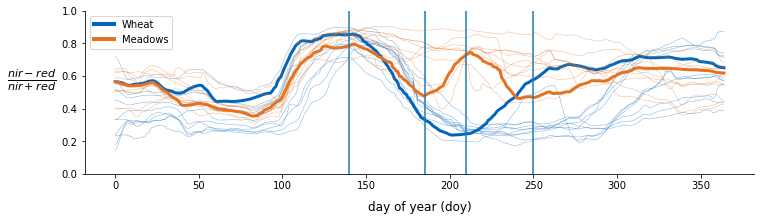

In [6]:
def ndvi(X):
    red = X[:,2]
    nir = X[:,3]
    return (nir-red) / (nir + red)

df = planetdataset.labels
class1_color = "#0065bd"
class2_color = "#e37222"



select_fid_class1=82235
select_fid_class2=43647

selected_times = [140,185,210,250]

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel("day of year (doy)", rotation=0, fontsize=12, labelpad=10)
ax.set_ylabel(r"$\frac{{nir}-{red}}{{nir}+{red}}$", rotation=0, fontsize=16, labelpad=30)
ax.set_ylim(0,1)
classes = ["Wheat", "Meadows"]
for classname, color, sel_fid in zip(classes,[class1_color, class2_color], [select_fid_class1,select_fid_class2]):

    N = 10
    fids = df.loc[df.crop_name == classname].fid.values

    
    for i in range(N):
        fid = fids[i]
        idx = np.argmax(df.fid == fid)
        X,y,id = planetdataset[idx]
        ts = X[:,:,id > 0].mean(-1)
        ax.plot(ndvi(ts),'-', linewidth=0.5, c=color,alpha=0.5)
        
    fid = sel_fid
    idx = np.argmax(df.fid == fid)
    X,y,id = planetdataset[idx]
    ts = X[:,:,id > 0].mean(-1)
    ax.plot(ndvi(ts), linewidth=3, c=color)

    sns.despine(offset=0)
    
[ax.axvline(t) for t in selected_times]
    
#lines = ax.plot(data)
custom_lines = [Line2D([0], [0], color=class1_color, lw=4),
                Line2D([0], [0], color=class2_color, lw=4)]

ax.legend(custom_lines, classes)
fname=os.path.join(fld,f"plots.pdf")
print(f"saving {fname}")
fig.savefig(fname, bbox_inches='tight', transparent=True)


saving /tmp/plots/82235_Wheat_images.pdf
saving /tmp/plots/43647_Meadows_images.pdf


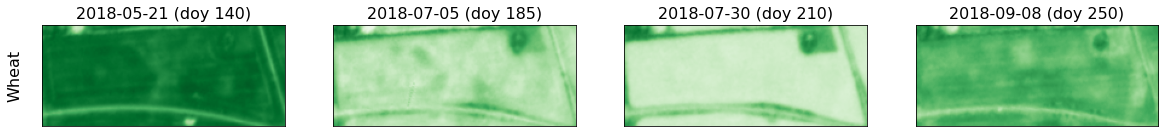

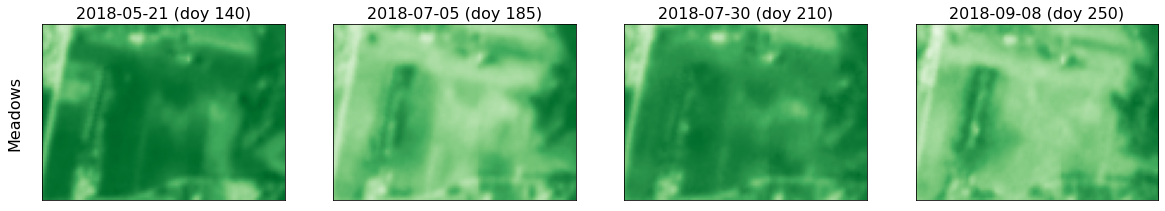

In [4]:

N = len(selected_times)

for sfid in [select_fid_class1,select_fid_class2]:
    idx = np.argmax(df.fid == sfid)
    X,y,id = planetdataset[idx]
    
    fig,axs = plt.subplots(1,N,figsize=(N*5,5))
    
    cl = CLASSES[y]

    for t, ax in zip(selected_times, axs):
        ax.imshow(ndvi(X)[t], cmap="Greens", vmin=0, vmax=1)
        
        
        ax.set_title(f"{(datetime(2018,1,1) + timedelta(days=t)).strftime('%Y-%m-%d')} (doy {t})", fontsize=16)
        
        #ax.get_yaxis().set_visible(False)
        #ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])

        ax.set_yticklabels([])
        ax.set_xticklabels([])

    
    axs[0].set_ylabel(cl, rotation=90, fontsize=16, labelpad=20)
        #ax.axis("off")#
        
    fname=os.path.join(fld,f"{sfid}_{cl}_images.pdf")
    print(f"saving {fname}")
    fig.savefig(fname, bbox_inches='tight', transparent=True)


## Sentinel 2

In [2]:
from s2dataset import S2DatasetV2, S2Dataset

import pickle
timsstampfile = "/ssd/ai4food_brandenburg/ai_for_food_sentinel/s2-utm-33N-18E-242N-2018/timestamp.pkl"

timestamps = np.array(pickle.load(open(timsstampfile,"rb")))
doy = np.array([dt.timetuple().tm_yday for dt in timestamps])

def s2transform(X,clp):
    msk = clp > 128
    X[msk[:,0],:] = np.nan
    return X

zippath = "/ssd/ai4food_brandenburg/ai_for_food_sentinel/s2-utm-33N-18E-242N-2018.zip"
labelgeojson = "/ssd/ai4food_brandenburg/brandenburg_crops_train_2018.geojson"
BANDS = ["B01","B02","B03","B04","B05","B06","B07","B08","B8A","B09","B11","B12"]
s2dataset = S2Dataset(zippath, labelgeojson, transform=s2transform)

saving /tmp/plots/plotss2.pdf


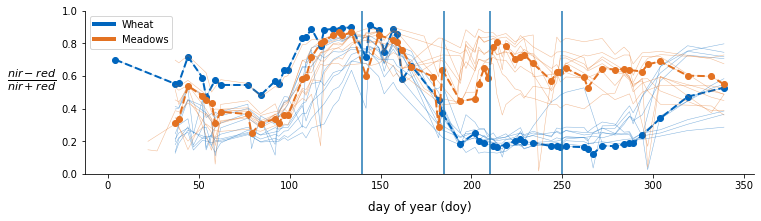

In [10]:

selected_times = [140,185,210,250]
df = s2dataset.labels

fig, ax = plt.subplots(figsize=(12,3))
ax.set_xlabel("day of year (doy)", rotation=0, fontsize=12, labelpad=10)
ax.set_ylabel(r"$\frac{{nir}-{red}}{{nir}+{red}}$", rotation=0, fontsize=16, labelpad=30)
ax.set_ylim(0,1)
classes = ["Wheat", "Meadows"]
for classname, color, sel_fid in zip(classes,[class1_color, class2_color], [select_fid_class1,select_fid_class2]):

    N = 10
    fids = df.loc[df.crop_name == classname].fid.values

    
    for i in range(N):
        fid = fids[i]
        idx = np.argmax(df.fid == fid)
        
        X,y,id = s2dataset[idx]

        cloudy = ~np.isnan(X[:,0])
        X = X[cloudy]
        doy_ = doy[cloudy]
        
        ts = X
        red_idx = BANDS.index("B04")
        nir_idx = BANDS.index("B08")

        n = (ts[:,nir_idx] - ts[:,red_idx]) / (ts[:,nir_idx] + ts[:,red_idx])
        
        ax.plot(doy_, n,'-', linewidth=0.5, c=color,alpha=0.5)
        
    fid = sel_fid
    X,y,id = s2dataset[idx]

    cloudy = ~np.isnan(X[:,0])
    X = X[cloudy]
    doy_ = doy[cloudy]
      
    ts = X
    red_idx = BANDS.index("B04")
    nir_idx = BANDS.index("B08")

    n = (ts[:,nir_idx] - ts[:,red_idx]) / (ts[:,nir_idx] + ts[:,red_idx])
    
    ax.plot(doy_, n, marker="o", linestyle="dashed" ,linewidth=2, c=color)

    sns.despine(offset=0)
    
[ax.axvline(t) for t in selected_times]
    
#lines = ax.plot(data)
custom_lines = [Line2D([0], [0], color=class1_color, lw=4),
                Line2D([0], [0], color=class2_color, lw=4)]

ax.legend(custom_lines, classes)
fname=os.path.join(fld,f"plotss2.pdf")
print(f"saving {fname}")
fig.savefig(fname, bbox_inches='tight', transparent=True)
